In [7]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure, morphology
from skimage.measure import regionprops
import math
import fitz

In [4]:
from signature_detect.loader import Loader
from signature_detect.extractor import Extractor
from signature_detect.cropper import Cropper
from signature_detect.judger import Judger

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
doc = fitz.open('./test_data/testpdf.pdf')

In [12]:
def text_size_check(page, debug_mode: bool = True):

    # gray
    gray = cv.cvtColor(page, cv.COLOR_BGR2GRAY)

    # blur
    blur = cv.GaussianBlur(gray, (7, 7), 0)

    # canny
    canny = cv.Canny(blur, 127, 200, apertureSize=3, L2gradient=True)

    # threshold
    _, threshold = cv.threshold(canny, 127, 200, cv.THRESH_BINARY)

    # contours
    contours, hierch = cv.findContours(threshold, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    max_cont_idx = -1
    max_cont_area = 0
    for i in range(len(contours)):
            if (hierch[0][i][1] >= 0) and (hierch[0][i][2] >= 0) and (hierch[0][i][3] >= 0):
                if max_cont_area < cv.contourArea(contours[i]):
                    max_cont_area = cv.contourArea(contours[i])
                    max_cont_idx = i
                    
    (x, y, w, h) = cv.boundingRect(contours[max_cont_idx])
    cv.rectangle(page, (x, y), (x + w, y + h), (0, 0, 250), 1)

    # TODO: fix text size check

    main_child_idx = 0
    for i in range(len(contours)):
        if hierch[0][i][3] == max_cont_idx:
            main_child_idx = i

    lowest_text = 0
    max_y = 0
    for i in range(len(contours)):
        if hierch[0][i][3] == main_child_idx:
            print(max_y)
            if max_y < cv.boundingRect(contours[i])[1]:
                max_y = cv.boundingRect(contours[i])[1]
                lowest_text = i

    (_x, _y, _w, _h) = cv.boundingRect(contours[lowest_text])
    cv.rectangle(page, (_x, _y), (_x + _w, _y + _h), (0, 255, 0), 2)
    if debug_mode:
        cv.imshow("page", page)
        cv.waitKey(0)
        cv.destroyAllWindows()
        
    if h / _h <= .7:
        return False
    else:
        return True


In [13]:
for i in range(doc.page_count):
    page = doc.load_page(i)
    pix = page.get_pixmap()
    page = np.frombuffer(pix.samples, np.uint8).reshape(pix.height, pix.width, 3)
    
    if page.shape[0] > page.shape[1]:
        text_size_check(page, debug_mode=False)

0
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
781
0
254
254
254
254
254
254
254
254
254
254


In [56]:
image = cv.imread('./data/imgasd.png')
#image = cv2.resize(image, (int(500 * 1.2980769230769231), 500))
output = image.copy()

In [57]:
def check_printing(page, low_threshold, high_treshold):

    # uncomment for testing
    test = page.copy()
    
    # gray
    gray = cv.cvtColor(page, cv.COLOR_BGR2GRAY)

    bilateral = cv.bilateralFilter(gray,10,50,50)

    # blur
    blur = cv.GaussianBlur(bilateral, (7, 7), 0)

    # поиск окружностей
    circles = cv.HoughCircles(blur, cv.HOUGH_GRADIENT_ALT, dp=2, minDist=page.shape[0] // 20, minRadius=50, maxRadius=100, param1=300, param2=0.9)
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")

        for (x, y, r) in circles:
            empty = np.zeros((gray.shape[0], gray.shape[1]), dtype="uint8")
            cv.circle(empty, (x, y), r, (255, 255, 255), -1)
            crop = gray * (empty.astype(gray.dtype))
            cv.imshow("empty", empty)
            cv.waitKey(0)
            cv.imshow('crop', crop)
            cv.waitKey(0)
            cv.destroyAllWindows()
            square_of_print = len(empty[empty > 200])
            print_pixels = len(crop[crop > 50])
            print_bg_pixels = square_of_print - print_pixels
            print(f'pixels ratio: {print_pixels / print_bg_pixels}')
    return False
    

In [58]:
check_printing(image, None, None)

QObject::moveToThread: Current thread (0x56023fff3aa0) is not the object's thread (0x5602407176b0).
Cannot move to target thread (0x56023fff3aa0)

QObject::moveToThread: Current thread (0x56023fff3aa0) is not the object's thread (0x5602407176b0).
Cannot move to target thread (0x56023fff3aa0)

QObject::moveToThread: Current thread (0x56023fff3aa0) is not the object's thread (0x5602407176b0).
Cannot move to target thread (0x56023fff3aa0)

QObject::moveToThread: Current thread (0x56023fff3aa0) is not the object's thread (0x5602407176b0).
Cannot move to target thread (0x56023fff3aa0)

QObject::moveToThread: Current thread (0x56023fff3aa0) is not the object's thread (0x5602407176b0).
Cannot move to target thread (0x56023fff3aa0)

QObject::moveToThread: Current thread (0x56023fff3aa0) is not the object's thread (0x5602407176b0).
Cannot move to target thread (0x56023fff3aa0)

QObject::moveToThread: Current thread (0x56023fff3aa0) is not the object's thread (0x5602407176b0).
Cannot move to tar

pixels ratio: 0.3334252619966906


QObject::moveToThread: Current thread (0x56023fff3aa0) is not the object's thread (0x5602407176b0).
Cannot move to target thread (0x56023fff3aa0)

QObject::moveToThread: Current thread (0x56023fff3aa0) is not the object's thread (0x5602407176b0).
Cannot move to target thread (0x56023fff3aa0)

QObject::moveToThread: Current thread (0x56023fff3aa0) is not the object's thread (0x5602407176b0).
Cannot move to target thread (0x56023fff3aa0)

QObject::moveToThread: Current thread (0x56023fff3aa0) is not the object's thread (0x5602407176b0).
Cannot move to target thread (0x56023fff3aa0)

QObject::moveToThread: Current thread (0x56023fff3aa0) is not the object's thread (0x5602407176b0).
Cannot move to target thread (0x56023fff3aa0)

QObject::moveToThread: Current thread (0x56023fff3aa0) is not the object's thread (0x5602407176b0).
Cannot move to target thread (0x56023fff3aa0)

QObject::moveToThread: Current thread (0x56023fff3aa0) is not the object's thread (0x5602407176b0).
Cannot move to tar

pixels ratio: 0.1783039058319957


False

In [21]:
def colored_mask(img, threshold = -1):
   # Размытие для удаления мелких шумов.
   denoised = cv.medianBlur(img, 3)

   # Сохранение в ЧБ для получения маски.
   gray = cv.cvtColor(denoised, cv.COLOR_BGR2GRAY)

   # Получение цветной части изображения.
   adaptiveThreshold = threshold if threshold >= 0 else cv.mean(img)[0]
   color = cv.cvtColor(denoised, cv.COLOR_BGR2HLS)
   mask = cv.inRange(color, (0, int(adaptiveThreshold / 6), 60), (180, adaptiveThreshold, 255))

   # Создание маски цветной части изображения.
   dst = cv.bitwise_and(gray, gray, mask=mask)
   return dst

In [4]:
image.shape

(800, 560, 3)

In [9]:
loader = Loader()

In [5]:
mask = colored_mask(image)
#blur = cv2.GaussianBlur(gray, (5, 5), 0)

NameError: name 'colored_mask' is not defined

In [191]:
cv2.imshow('kek', mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [199]:
circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, dp=2, minDist=20, minRadius=20, maxRadius=60)

In [200]:
circles.shape

(1, 6, 3)

In [201]:
circles

array([[[ 99. , 623. ,  47.8],
        [115. , 635. ,  52.2],
        [ 89. , 641. ,  52.2],
        [115. , 609. ,  50. ],
        [ 77. , 623. ,  50. ],
        [ 99. , 595. ,  36.8]]], dtype=float32)

In [202]:
circles = np.uint16(np.around(circles))

In [205]:
result = []

def equals(first, second, epsilon):
   diff = cv2.subtract(first, second)
   nonZero = cv2.countNonZero(diff)
   area = first.size * epsilon
   return nonZero <= area

for i in circles[0, :]:
   empty = np.zeros((700, 621), dtype="uint8")
   cv2.circle(empty, (i[0], i[1]), i[2], (255, 255, 255), -1)
   crop = mask * (empty.astype(mask.dtype))

   if not equals(crop, empty, 1):
       result.append(i)

In [206]:
result

[]

In [159]:
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circles:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)
        #cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
    # show the output output
    cv2.imshow("output", output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [160]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.imshow(img)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Image

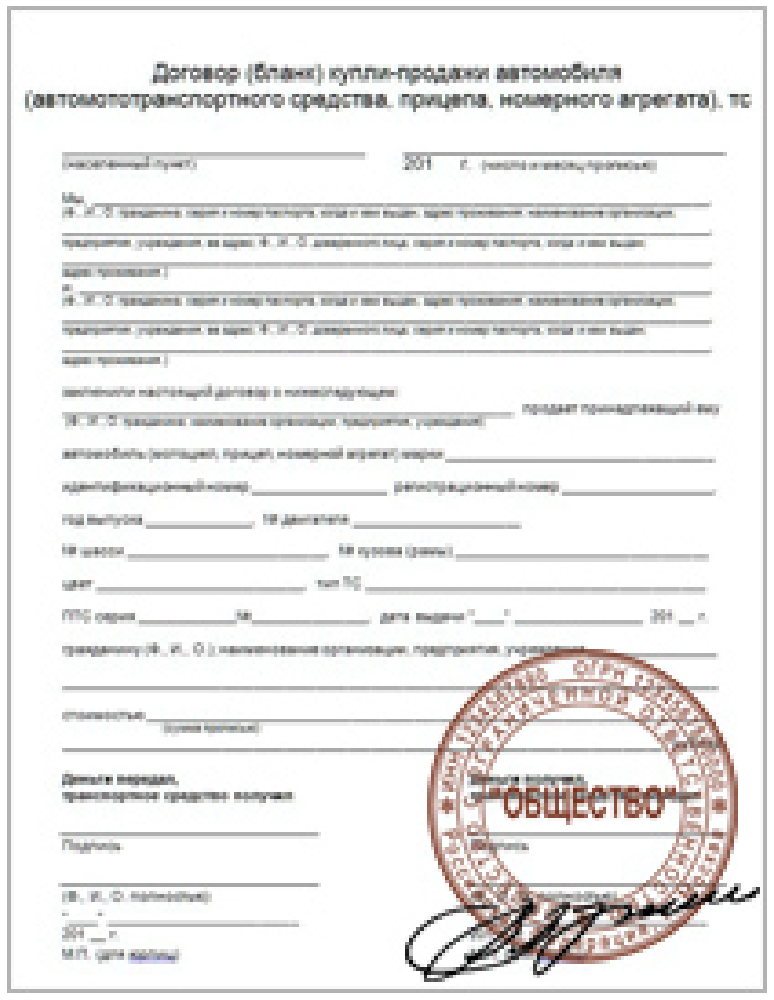

In [40]:
path = './data/doc-sign.jpg'
image = cv2.imread('./data/doc-sign.jpg')
show_image(image)

## Loader

The loader reads the file and creates a mask. 

The mask is a numpy array. The bright parts are set to 255, the rest is set to 0.

In [41]:
loader = Loader()
print(loader)


Loader
low_threshold = (0, 0, 250)
high_threshold = (255, 255, 255)



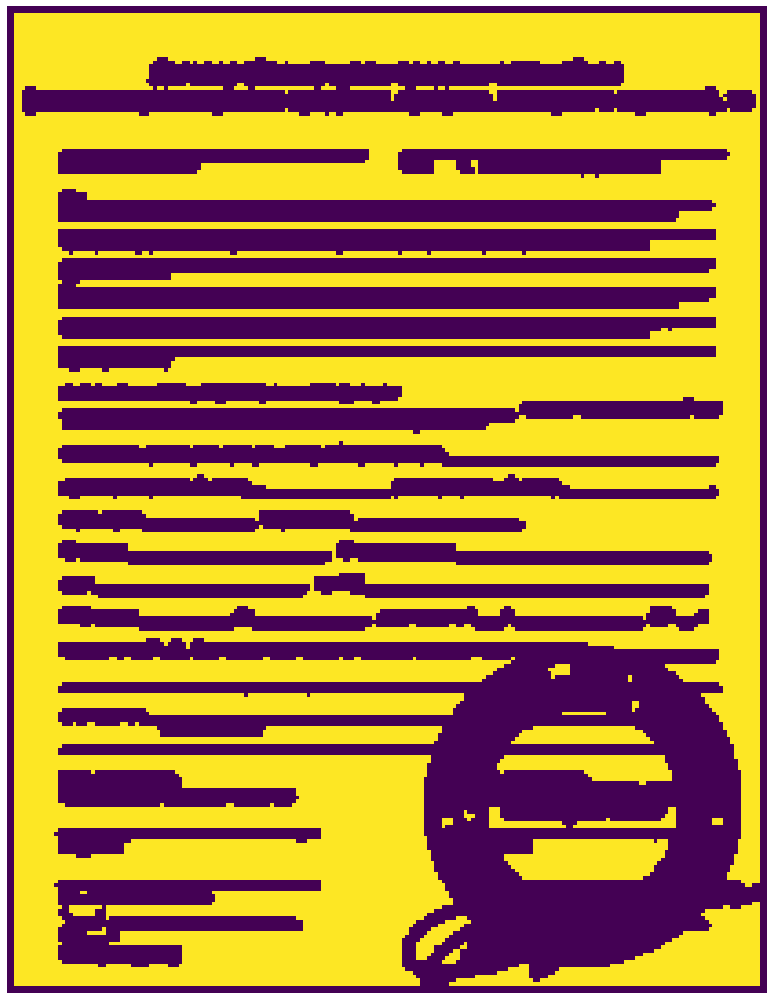

In [42]:
mask = loader.get_masks(image)
show_image(mask)
# plt.imsave('./data/output/mask.jpeg', mask)

## Extractor

The extractor 

1. generates the regions from the mask.
2. removes the small and the big region because the signature is neither too big nor too small.

In [43]:
extractor = Extractor(outlier_weight=1, outlier_bias=50, amplfier=15, min_area_size=10)
print(extractor)


Extractor
outlier_weight = 1
outlier_bias = 50
> small_outlier_size = outlier_weight * average_region_size + outlier_bias
amplfier = 15
> large_outlier_size = amplfier * small_outlier_size
min_area_size = 10 (pixels)
> min_area_size is used to calculate average_region_size.



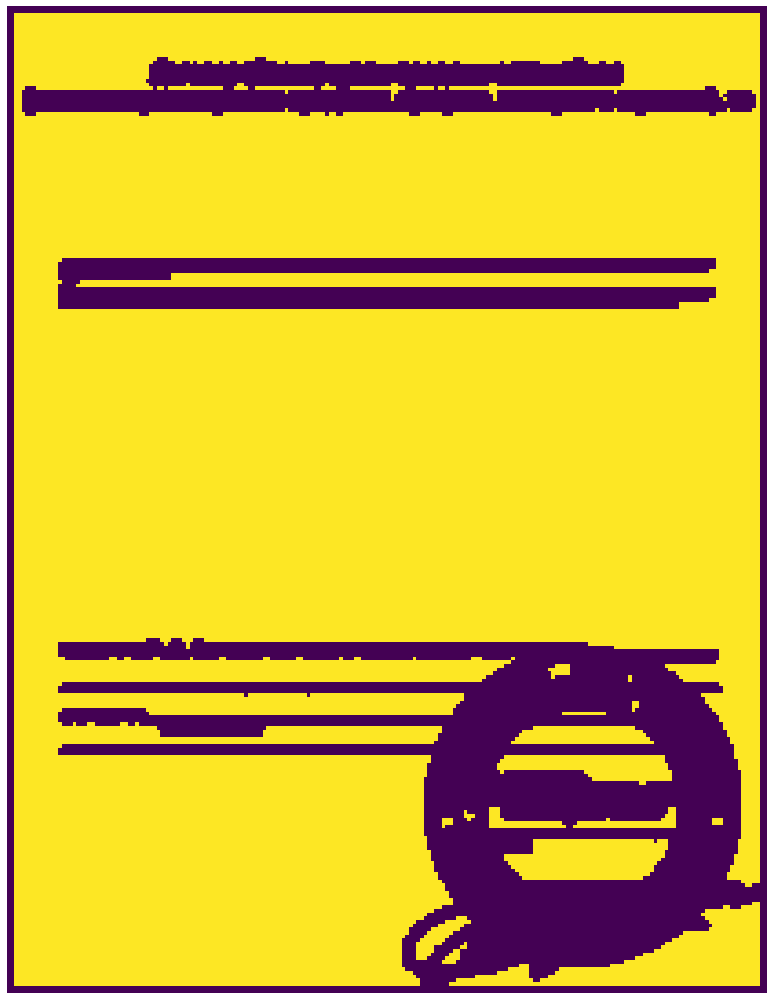

In [44]:
labeled_mask = extractor.extract(mask)
show_image(labeled_mask)
#plt.imsave('labeled_mask.png', labeled_mask)

## Cropper

The cropper finds the **contours** of regions in the **labeled masks** and crop them.

In [45]:
cropper = Cropper(min_region_size=2000, border_ratio=0.1)
print(cropper)


Cropper
min_region_size = 2000
border_ratio = 0.1



In [46]:
results = cropper.run(labeled_mask)

In [47]:
len(results)

3

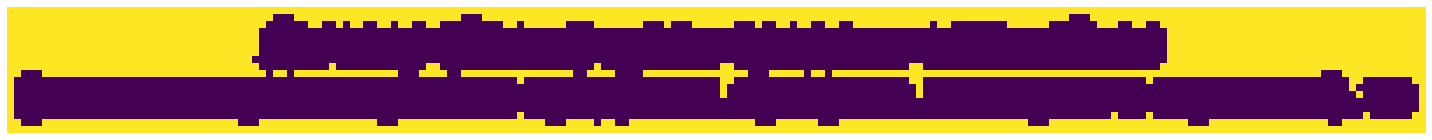

In [51]:
show_image(results[1]['cropped_mask'])

In [32]:
circles = cv2.HoughCircles(results[0]['cropped_mask'], cv2.HOUGH_GRADIENT, dp=2, minDist=results[0]['cropped_mask'].shape[0], minRadius=20, maxRadius=60)

In [35]:
circles = np.round(circles[0, :]).astype("int")

In [36]:
kek = results[0]['cropped_mask'].copy()

In [39]:
(x, y, r) = circles[0]
cv2.circle(kek, (x, y), r, (0, 255, 0), -1)
cv2.imshow("kek", kek)
cv2.waitKey(0)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x5571f8271ff0) is not the object's thread (0x5571f8b9c5b0).
Cannot move to target thread (0x5571f8271ff0)

QObject::moveToThread: Current thread (0x5571f8271ff0) is not the object's thread (0x5571f8b9c5b0).
Cannot move to target thread (0x5571f8271ff0)

QObject::moveToThread: Current thread (0x5571f8271ff0) is not the object's thread (0x5571f8b9c5b0).
Cannot move to target thread (0x5571f8271ff0)

QObject::moveToThread: Current thread (0x5571f8271ff0) is not the object's thread (0x5571f8b9c5b0).
Cannot move to target thread (0x5571f8271ff0)

QObject::moveToThread: Current thread (0x5571f8271ff0) is not the object's thread (0x5571f8b9c5b0).
Cannot move to target thread (0x5571f8271ff0)

QObject::moveToThread: Current thread (0x5571f8271ff0) is not the object's thread (0x5571f8b9c5b0).
Cannot move to target thread (0x5571f8271ff0)

QObject::moveToThread: Current thread (0x5571f8271ff0) is not the object's thread (0x5571f8b9c5b0).
Cannot move to tar

## Judger

The judger reads the cropped mask and identifies if it's a signature or not.

In [164]:
judger = Judger(size_ratio=[1, 4], pixel_ratio=[0.1, 0.7])
print(judger)
flag = False
for i in range(len(results)):
    res = judger.judge(results[i]['cropped_mask'])
    if res:
        flag = True
print(flag)


Judger
size_ratio = [1, 4]
pixel_ratio = [0.1, 0.7]

pixel_ratio: 1.183259911894273
pixel_ratio: 0.20237892948173322
pixel_ratio: 1.1258603736479842
True
